# Analyse des données extraite via Graal

## Ouverture de data.csv et insertion dans df

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
from py4j.java_gateway import JavaGateway
import re
import matplotlib.pyplot as plt
#Fonction pour clean le data (le plus générale possible)
def cleanData(df,columns,vide):
    #on ajoute le header
    df.columns =columns
    #On récupère que les valeurs entre guillemets
    df= df.applymap(lambda x: re.search(r'(^.*"(.*)\")',str(x)).group(2))

    #Passage NaN au valeur aillant le mot vide
    for column in df.columns[0:]:
        df.loc[df[column]==vide,column]=np.nan
    return df



#Début Méthode 1 : Requêtage direct de la KB Graal
gateway = JavaGateway()

graal = gateway.entry_point
print(graal)


dataQuery = graal.evaluate("?(A,B,C,D,M,E,F,G,H,K) :- " + " passagerRelation(A,B,C,D)," + " cabineRelation(A,B,M)," + " aPourClasse(A,B,E)," + " voyageTitanic(A,B,F,G,H,I,J,K,L).")
checkQuery1 = graal.evaluate("?(A,B,G) :- " + " voyageTitanic(A,B,X,Y,O,P,G,L,N).")
checkQuery2 = graal.evaluate("?(A,B,G) :- " + " voyageTitanic2(G,A,B,X,Y,O,P,L,N).")

testData = []
check1 = []
check2 = []



while dataQuery.hasNext():
    testData.append(dataQuery.next().toString())

while checkQuery1.hasNext():
    check1.append(checkQuery1.next().toString())
    
while checkQuery2.hasNext():
    check2.append(checkQuery2.next().toString())

j = 0
while j != len(testData):
    for i in testData:
        testData[j] = testData[j].replace('{','')
        testData[j] = testData[j].replace('}','')
        testData[j] = testData[j].replace('->','')
        testData[j] = testData[j].replace('M','')
        testData[j] = testData[j].replace('H','')
        testData[j] = testData[j].replace('K','')  
        testData[j] = testData[j].replace('E','')
        testData[j] = testData[j].replace('D','')
        testData[j] = testData[j].replace('G','')
        testData[j] = testData[j].replace('F','')
        testData[j] = testData[j].replace('A','')
        testData[j] = testData[j].replace('C','')
        testData[j] = testData[j].replace('B','')
        testData[j] = testData[j].split(",")
        j+=1

print(testData[0])

z = 0
while z != len(check1):
    for i in check1:
        check1[z] = check1[z].replace('{','')
        check1[z] = check1[z].replace('}','')
        check1[z] = check1[z].replace('->','')
        check1[z] = check1[z].replace('G','')
        check1[z] = check1[z].replace('A','')
        check1[z] = check1[z].replace('B','')
        check1[z] = check1[z].split(",")
        z+=1

print(check1[0])

t = 0
while t != len(check2):
    for i in check2:
        check2[t] = check2[t].replace('{','')
        check2[t] = check2[t].replace('}','')
        check2[t] = check2[t].replace('->','')
        check2[t] = check2[t].replace('G','')
        check2[t] = check2[t].replace('A','')
        check2[t] = check2[t].replace('B','')
        check2[t] = check2[t].split(",")
        t+=1

print(check2[0])


print("Extrait méthode 1 : ")
dfTemp2 = pd.DataFrame(testData,index = None,columns = ["pclass","sex","parch","ticket","boat","sibsp","embarked","lastname","age","firstname"])



print(dfTemp2.loc[0])

#Fin Méthode 1

#Début Méthode 2 : Extraction du résultat des requêtes dans un fichier

#on transforme en dataframe
df = pd.read_csv("data.csv", header=None)
#Définition du header
columns = ["embarked","sibsp","boat","pclass","sex","parch","ticket","lastname","age","firstname"]  
#indication du mot vide (modulable selon si c'est ?, Unknown,null, NULL etc)
vide = 'null'

print("Extrait méthode 2 :")
df = cleanData(df,columns,vide)
df.head()


fr.Graal.testJar.mainExemple@5690e2a0
['"1"', '"male"', '"0"', '"P 17755"', '"1"', '"3"', '"51 53 55"', '"ardeza"', '"36.0"', '"r. Thomas rake artinez"']
['"0"', '"Saad"', '"Mr. min"']
['"0 "', '"Matinoff "', '"Mr. Nicola "']
Extrait méthode 1 : 
pclass                            "1"
sex                            "male"
parch                             "0"
ticket                      "P 17755"
boat                              "1"
sibsp                             "3"
embarked                   "51 53 55"
lastname                     "ardeza"
age                            "36.0"
firstname    "r. Thomas rake artinez"
Name: 0, dtype: object
Extrait méthode 2 :


,embarked,sibsp,boat,pclass,sex,parch,ticket,lastname,age,firstname
0,NaN,1.0,NaN,2,F,1.0,250651,Lahtinen,26.0,Mrs. William (Anna Sylfven)
1,NaN,1.0,NaN,2,M,1.0,250651,Lahtinen,30.0,Rev. William
2,E8,0,5,1,male,1,113806,Chambers,27.0,Mr. Norman Campbell
3,E8,0,5,1,female,1,113806,Chambers,33.0,Mrs. Norman Campbell (Bertha Griggs)
4,NaN,0.0,NaN,2,M,0.0,SC 14888,Parker,28.0,Mr. Clifford Richard


## Ouverture de check.csv

In [34]:
dfSurvived = pd.read_csv("check.csv", header=None)
columns = ["survived","lastname","firstname"]   
dfSurvived = cleanData(dfSurvived,columns,vide)
dfSurvived.head()

,survived,lastname,firstname
0,0,Lindblom,Miss. Augusta Charlotta
1,0,McCrie,Mr. James Matthew
2,1,Baclini,Miss. Eugenie
3,0,Rice,Master. Arthur
4,1,Davies,Master. John Morgan Jr


## Fusion

In [35]:
df = pd.merge(df,dfSurvived, on=['firstname', 'lastname'])
df.head()

,embarked,sibsp,boat,pclass,sex,parch,ticket,lastname,age,firstname,survived
0,NaN,1.0,NaN,2,F,1.0,250651,Lahtinen,26.0,Mrs. William (Anna Sylfven),0
1,NaN,1.0,NaN,2,M,1.0,250651,Lahtinen,30.0,Rev. William,0
2,E8,0,5,1,male,1,113806,Chambers,27.0,Mr. Norman Campbell,1
3,E8,0,5,1,female,1,113806,Chambers,33.0,Mrs. Norman Campbell (Bertha Griggs),1
4,NaN,0.0,NaN,2,M,0.0,SC 14888,Parker,28.0,Mr. Clifford Richard,0


## Analyses des données

<AxesSubplot:>

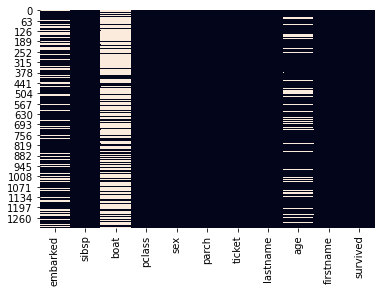

In [36]:
sns.heatmap(df.isnull(), cbar=False)

In [37]:
#transformation des zone numériques (object -> int/float)
df['pclass']=df['pclass'].astype(int)
df['survived']= df['survived'].astype(int)
df['parch']= df['parch'].astype(float)
df['sibsp']= df['sibsp'].astype(float)
df['age']= df['age'].astype(float)
df.describe(include=['O'])

,embarked,boat,sex,ticket,lastname,firstname
count,999,370,1320,1320,1320,1320
unique,179,73,4,929,875,1141
top,S,4,male,CA. 2343,Kelly,Mr. James
freq,498,32,678,11,11,15


In [38]:
df[['pclass', 'survived']].groupby(['pclass'], as_index=False).mean().sort_values(by='survived', ascending=False)

,pclass,survived
0,1,0.618012
1,2,0.429603
2,3,0.255201


In [39]:
df[["sex", "survived"]].groupby(['sex'], as_index=False).mean().sort_values(by='survived', ascending=False)

,sex,survived
0,F,0.886792
2,female,0.676712
3,male,0.200590
1,M,0.146199


In [40]:
df[["sibsp", "survived"]].groupby(['sibsp'], as_index=False).mean().sort_values(by='survived', ascending=False)

,sibsp,survived
3,3.0,0.625000
1,1.0,0.588235
2,2.0,0.504425
0,0.0,0.333662
4,4.0,0.166667
5,5.0,0.166667
6,6.0,0.000000
7,9.0,0.000000


In [41]:
df[["parch", "survived"]].groupby(['parch'], as_index=False).mean().sort_values(by='survived', ascending=False)

,parch,survived
1,1.0,0.509434
2,2.0,0.452381
0,0.0,0.345515
3,3.0,0.300000
4,4.0,0.136364
5,5.0,0.000000
6,8.0,0.000000


In [42]:
    df[["age", "survived"]].groupby(['age'], as_index=False).mean().sort_values(by='survived', ascending=False)
    #ajouter % âge pour graphique

,age,survived
0,0.1667,1.0
6,0.9167,1.0
96,76.0000,1.0
75,53.0000,1.0
19,12.0000,1.0
...,...,...
58,38.5000,0.0
68,46.0000,0.0
67,45.5000,0.0
61,40.5000,0.0


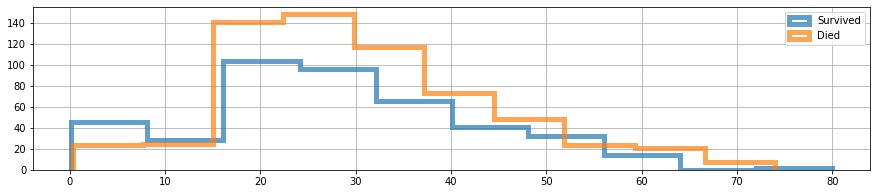

In [43]:
plt.rcParams["figure.figsize"] = (15,3)
#nombre de personnes en vie/morte suivant leur ages
df.loc[df["survived"] == 1,"age"].hist(alpha = 0.7,fill=False, histtype='step',linewidth=5);
df.loc[df["survived"] == 0,"age"].hist(alpha = 0.7,fill=False, histtype='step',linewidth=5).legend(["Survived","Died"]);

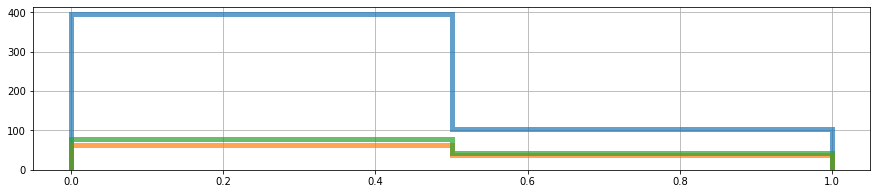

In [44]:
plt.rcParams["figure.figsize"] = (15,3)
#nombre de personnes en vie/morte suivant leur embarcation (pas pertinent mais par curiosité)
df.loc[df["embarked"] == 'S',"survived"].hist(alpha = 0.7,fill=False,range = (0, 1),bins = 2, histtype='step',linewidth=5);
df.loc[df["embarked"] == 'C',"survived"].hist(alpha = 0.7,fill=False,range = (0, 1),bins = 2, histtype='step',linewidth=5);
df.loc[df["embarked"] == 'Q',"survived"].hist(alpha = 0.7,fill=False,range = (0, 1),bins = 2, histtype='step',linewidth=5);

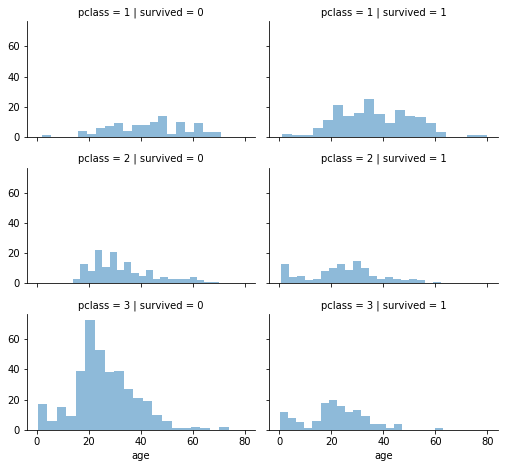

In [45]:
grid = sns.FacetGrid(df, col='survived', row='pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'age', alpha=.5, bins=20)
grid.add_legend();

Pour la classification il faut :
    numéroter les age selon une periode ex : [0,5] = 1  [5,10]=2 ....
    numéroter les fare selon une tranche de prix
    attribuer un chiffre a chaque lettre de embarked
    attribuer un chiffe a chaque sex
    attribuer un chiffre pour la partie nom:
        On peut s'intéresser uniquement au nom de famille a qui on attribut un chiffre
        On  peut s'intéresser uniquement à la classe sociale "miss" , "mister"..
    s'interesser au sibsp, parch de façons différente
        seulement notifier si la personne est seul
        additionner les deux et faire une tranche 0 = 0  [1,3] = 1, [4,6]=2 ....

## transformation des données

In [46]:
def get_title(string):
    import re
    regex = re.compile(r'Mr|Don|Major|Capt|Jonkheer|Rev|Col|Dr|Mrs|Countess|Dona|Mme|Ms|Miss|Mlle|Master', re.IGNORECASE)
    results = regex.search(string)
    if results != None:
        return(results.group().lower())
    else:
        return(str(np.nan))
    
title_dictionary = {
    "capt":"Officer", 
    "col":"Officer", 
    "major":"Officer", 
    "dr":"Officer",
    "jonkheer":"Royalty",
    "rev":"Officer",
    "countess":"Royalty",
    "dona":"Royalty",
    "lady":"Royalty",
    "don":"Royalty",
    "mr":"Mr",
    "mme":"Mrs",
    "ms":"Mrs",
    "mrs":"Mrs",
    "miss":"Miss",
    "mlle":"Miss",
    "master":"Master",
    "nan":"Mr"
}



#si il n'y as pas l'age on met le median selon son titre
title_list = ['Mr','Miss','Mrs','Master', 'Royalty', 'Officer']
def age_nan_replace(means, dframe, title_list):
    for title in title_list:
        temp = dframe['title'] == title #extract indices of samples with same title
        dframe.loc[temp, 'age'] = dframe.loc[temp, 'age'].fillna(means[title]) # replace nan values for mean


In [47]:
#embarked/boat/lastname/ticket n'est pas très pertinent
df = df.drop(columns=['embarked'])
df = df.drop(columns=['boat'])
df = df.drop(columns=['lastname'])
df = df.drop(columns=['ticket'])

#addition de la famille et suppression de parch et sibsp
df["fsize"]= df.apply(lambda x: x.sibsp+x.parch, axis=1)
df = df.drop(columns=['parch', 'sibsp'])


#ajout titre
df["title"] = df["firstname"].apply(get_title)
#mapping titre
df["title"]  = df["title"].map(title_dictionary)
means_title = df.groupby('title')["age"].mean()
#age selon la moyenne par title
age_nan_replace(means_title, df, title_list)



dummies = []
cols = ['pclass', 'sex']
for col in cols:
    dummies.append(pd.get_dummies(df[col]))
titanic_dummies = pd.concat(dummies, axis=1)
df = pd.concat((df,titanic_dummies), axis=1)

df = df.drop(columns=['sex'])
df = df.drop(columns=['firstname'])
df = df.drop(columns=['pclass'])

df.head()

,age,survived,fsize,title,1,2,3,F,M,female,male
0,26.0,0,2.0,Mr,0,1,0,1,0,0,0
1,30.0,0,2.0,Officer,0,1,0,0,1,0,0
2,27.0,1,1.0,Mr,1,0,0,0,0,0,1
3,33.0,1,1.0,Mr,1,0,0,0,0,1,0
4,28.0,0,0.0,Mr,0,1,0,0,1,0,0


In [48]:


from sklearn.preprocessing import StandardScaler

numericals_list = ['age','']
for column in numericals_list:
    sc = StandardScaler(with_mean=True, with_std=True)
#    print(training_set[column].size)
#    print(test_set[column].size)
    sc.fit(df[column].values.reshape(-1,1))
    df[column] = sc.transform(df[column].values.reshape(-1,1))




from sklearn.preprocessing import LabelEncoder
categorical_classes_list = ['title'] #Pclass is already encoded
#encode features that are cateorical classes
encoding_list = []
for column in categorical_classes_list:
    le = LabelEncoder()
    le.fit(df[column])
    encoding_list.append(df[column].unique())
    df[column] = le.transform(df[column])



KeyError: ''

In [ ]:
df.head()

In [49]:
df.to_csv('titanic.preprocessing.csv', index=False)

In [50]:
df = pd.read_csv("titanic.preprocessing.csv")

y = df['survived'].values
X = df.drop(['survived'], axis=1).values

In [51]:
from sklearn.naive_bayes import GaussianNB
import re
import pandas as pd
import numpy as np
import itertools
import string

from sklearn.datasets import make_hastie_10_2, make_classification
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier , GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict, KFold, cross_val_score, train_test_split, RepeatedKFold
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import resample

# evaluate a logistic regression model using repeated k-fold cross-validation
from numpy import mean
from numpy import std
import time
models = []
models.append(('LR', LogisticRegression()))
models.append(('MLR',LogisticRegression(multi_class='multinomial',solver ='newton-cg')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVC', SVC(gamma='auto')))
models.append(('LSVC', LinearSVC(max_iter=3000)))

from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
kfold = RepeatedKFold(n_splits=10,n_repeats=3, random_state=7)

In [52]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import time
seed = 7
results = []
names = []
scoring='accuracy'

for name,model in models:
    start_time = time.time()
    cv_results = cross_val_score(model,X, y, cv=kfold, scoring=scoring)
    print ("Time pour",name," ",time.time() - start_time)
    results.append(cv_results)
    names.append(name )
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)    
    



Time pour LR   0.08478283882141113
LR: nan (nan)
Time pour MLR   0.02595829963684082
MLR: nan (nan)
Time pour KNN   0.04887986183166504
KNN: nan (nan)
Time pour SVC   0.04487013816833496
SVC: nan (nan)
Time pour LSVC   0.038895368576049805
LSVC: nan (nan)


[Text(1, 0, 'LR'),
 Text(2, 0, 'MLR'),
 Text(3, 0, 'KNN'),
 Text(4, 0, 'SVC'),
 Text(5, 0, 'LSVC')]

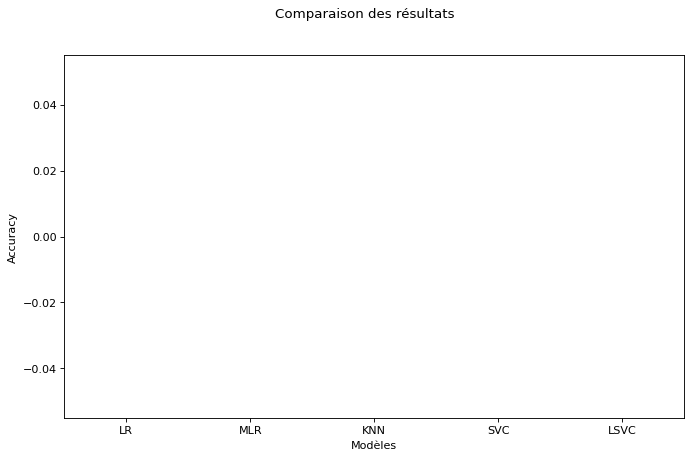

In [54]:
import warnings
warnings.filterwarnings('ignore')

fig = plt.figure(figsize=(10, 6), dpi=80)
fig.suptitle('Comparaison des résultats')
plt.ylabel('Accuracy')
plt.xlabel('Modèles')
ax = fig.add_subplot(111)
plt.boxplot(results,showfliers=False)
ax.set_xticklabels(names)